In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np

import matplotlib.pyplot as plt
import graphviz
import os

os.environ['PATH'] = os.environ['PATH'] + ';C:/Program Files (x86)/Graphviz2.38/bin'
plt.style.use('bmh')

#from stop_words import get_stop_words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_nltk = nltk.corpus.stopwords.words('portuguese')


datapath = '../../Data/Processed/intervencao_eqp.parquet'



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Janine\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


### <span style="color:Indigo">0. Adição de novas palavras ao Stopwords </span>

In [2]:
stopwords_nltk.append('equipe')
stopwords_nltk.append('kv')
stopwords_nltk.append('mw')
stopwords_nltk.append('quente')
stopwords_nltk.append('ponto')
stopwords_nltk.append('230')
stopwords_nltk.append('nº')
stopwords_nltk.append('comando')
stopwords_nltk.append('contatos')
stopwords_nltk.append('sistema')
stopwords_nltk.append('realizar')
stopwords_nltk.append('novo')
stopwords_nltk.append('01')
stopwords_nltk.append('10')
stopwords_nltk.append('02')
stopwords_nltk.append('03')
stopwords_nltk.append('13')
stopwords_nltk.append('08')
stopwords_nltk.append('equipamentos')
stopwords_nltk.append('pm04')
stopwords_nltk.append('st6')
stopwords_nltk.append('nova')
stopwords_nltk.append('ii')
stopwords_nltk.append('ons')

### <span style="color:Indigo">1. Formato do Database (parquet)</span>

In [3]:
dataframe = pd.read_parquet(datapath)

print('shape:', dataframe.shape)
print('columns:', dataframe.columns)

shape: (267318, 2)
columns: Index(['CLASSE', 'TEXTO'], dtype='object')


### <span style="color:Indigo">2. Distribuição das Classes da coluna 'CLASSE'</span>

In [4]:
dataframe.CLASSE.value_counts()

POS    178675
NEG     88643
Name: CLASSE, dtype: int64

#### <span style="color:BlueViolet">2.1 Grafico da Distribução </span>

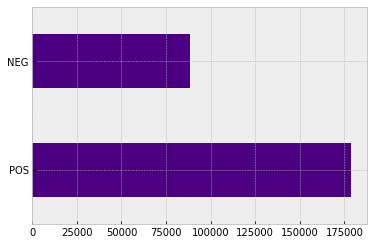

In [5]:
dataframe.CLASSE.value_counts().plot(kind='barh',color="Indigo")

#### <span style="color:DimGray">3. Distribuição das Classes da coluna 'TEXTO' </span>

##### <span style="color:DimGray"> Devido ao processamento lento, os comandos estão em comentário</span>

##### <span style="color:Gray">*dataframe.TEXTO.value_counts()* </span>
##### <span style="color:Gray">*dataframe.TEXTO.value_counts().plot(kind='bar')* </span>
</span>

### <span style="color:Indigo"> 4. Frequência de cada palavra (Em PORTUGUÊS) - **Biblioteca NLTK** </span>

In [6]:
vectorizer = CountVectorizer(dataframe.TEXTO.values.tolist(),encoding="utf-8",
                             stop_words= stopwords_nltk,
                             ngram_range = (1, 2),
                             min_df = 0.01,
                             max_df = 0.99,
                            )
text_counts = vectorizer.fit_transform(dataframe.TEXTO.values.tolist())
text_counts

<267318x185 sparse matrix of type '<class 'numpy.int64'>'
	with 1183832 stored elements in Compressed Sparse Row format>

#### <span style="color:BlueViolet"> 4.1. Contador de Palavras - PT </span>

Text(0.5, 0, '# Ocorrência das palavras')

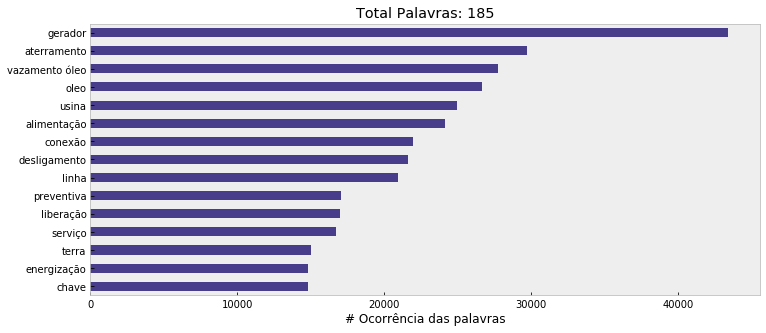

In [7]:
plt.figure(figsize=(12,5))
nshow = 15
word_count = np.asarray(text_counts.sum(axis=0))[0]

df_counts =pd.Series(word_count)
df_counts.index = list(vectorizer.vocabulary_.keys())
df_counts.sort_values().iloc[-nshow:].plot.barh(color='#483D8B')

plt.grid()
plt.title('Total Palavras: '+ str(word_count.shape[0]))
plt.xlabel('# Ocorrência das palavras')

#### <span style="color:BlueViolet"> 4.2. Distribuição da contagem de palavras - PT </span>

Text(0.5, 0, '# Ocorrência das palavras')

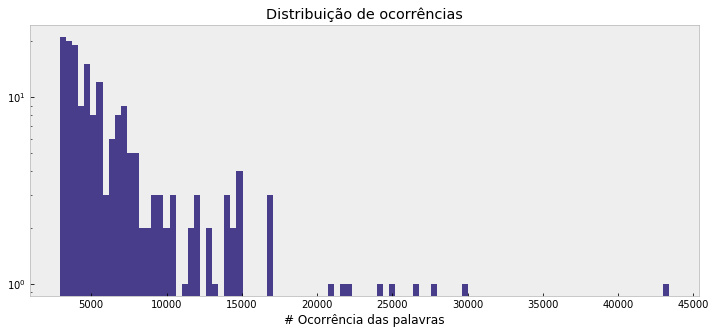

In [8]:
plt.figure(figsize=(12,5))

df_counts.hist(bins=100, color='#483D8B')

plt.grid()
plt.yscale('log')
plt.title('Distribuição de ocorrências')
plt.xlabel('# Ocorrência das palavras')

### <span style="color:Indigo">  6. Distribuição por classe</span>

Text(0.5, 1.0, 'Proporção Por Classe')

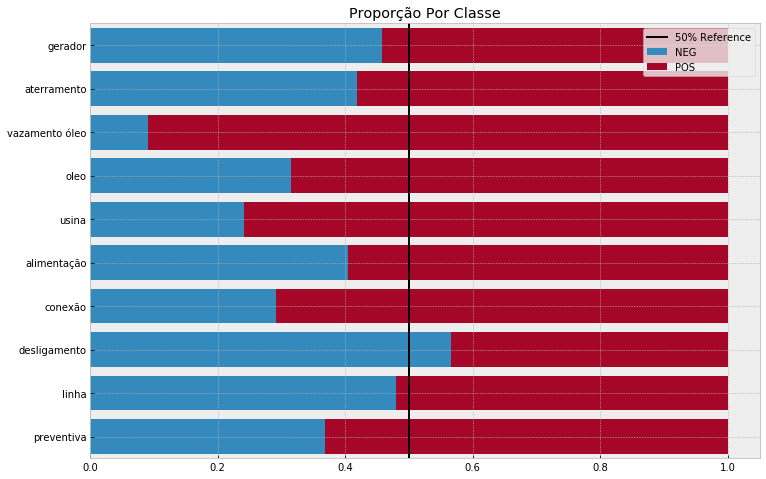

In [9]:
plt.figure(figsize=(12,8))

nshow = 10

idx = (dataframe['CLASSE'] == 'POS').values
word_count_neg = np.asarray(text_counts[~idx].mean(axis=0))[0]
word_count_pos = np.asarray(text_counts[ idx].mean(axis=0))[0]
idx = np.argsort(word_count)[-nshow:]
vocabulary = np.array(list(vectorizer.vocabulary_.keys()))[idx].tolist()
yaxis = np.arange(nshow)

total_count = word_count_neg + word_count_pos

bar_neg = plt.barh(yaxis, word_count_neg[idx] / total_count[idx], label='NEG')
bar_pos = plt.barh(yaxis, word_count_pos[idx] / total_count[idx],
                   left=word_count_neg[idx] / total_count[idx], label='POS')

plt.plot([0.5, 0.5],[-0.5, nshow], '-k', label='50% Reference')
plt.yticks(yaxis, vocabulary)
plt.legend()
plt.ylim((-0.5, nshow-0.5))

plt.title('Proporção Por Classe')


### <span style="color:Indigo">  7. Normalização por TF-IDF </span>

In [10]:
vectorizer = TfidfVectorizer(dataframe.TEXTO.values.tolist(),
                             stop_words= stopwords_nltk,
                             ngram_range = (1, 2),
                             min_df = 0.05,
                             max_df = 0.95)

text_features = vectorizer.fit_transform(dataframe.TEXTO.values.tolist())
vocabulary = list(vectorizer.vocabulary_.keys())
text_features

<267318x12 sparse matrix of type '<class 'numpy.float64'>'
	with 250843 stored elements in Compressed Sparse Row format>

### <span style="color:Indigo">  8. Distribuição Percentual  </span>

Text(0.5, 1.0, 'Proporção Por Classe')

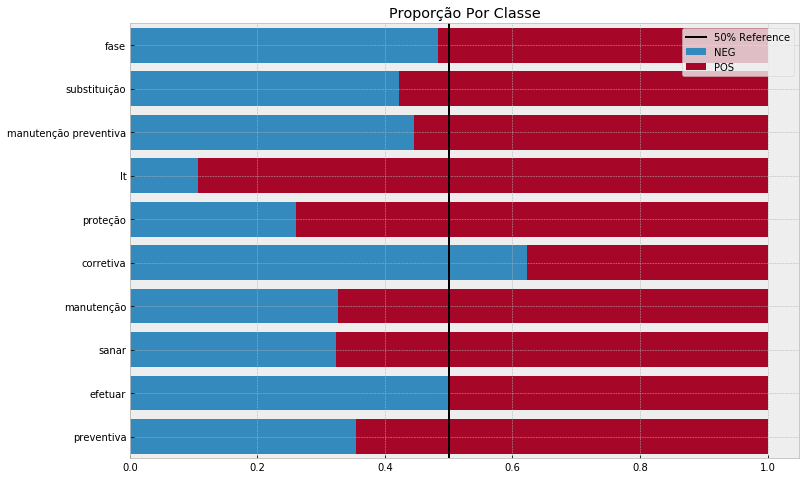

In [11]:
plt.figure(figsize=(12,8))

nshow = 10

idx = (dataframe['CLASSE'] == 'POS').values
word_count = np.asarray(text_features.mean(axis=0))[0]
word_count_neg = np.asarray(text_features[~idx].mean(axis=0))[0]
word_count_pos = np.asarray(text_features[ idx].mean(axis=0))[0]
idx = np.argsort(word_count)[-nshow:]
vocabulary = np.array(list(vectorizer.vocabulary_.keys()))[idx].tolist()
yaxis = np.arange(nshow)

total_count = word_count_neg + word_count_pos

bar_neg = plt.barh(yaxis, word_count_neg[idx] / total_count[idx], label='NEG')
bar_pos = plt.barh(yaxis, word_count_pos[idx] / total_count[idx],
                   left=word_count_neg[idx] / total_count[idx], label='POS')

plt.plot([0.5, 0.5],[-0.5, nshow], '-k', label='50% Reference')
plt.yticks(yaxis, vocabulary)
plt.legend()
plt.ylim((-0.5, nshow-0.5))

plt.title('Proporção Por Classe')



### <span style="color:Indigo">  9. Distribuição do TfIdf Médio por Classe </span>

Text(0.5, 0, 'TfIdf médio')

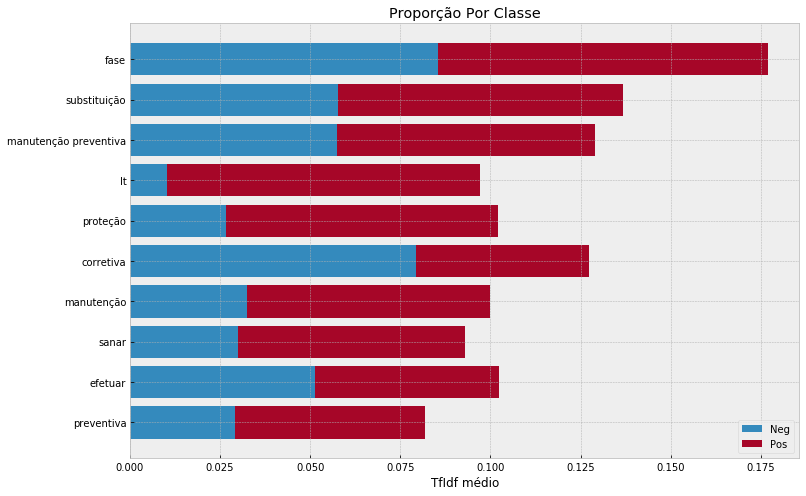

In [12]:
plt.figure(figsize=(12,8))


nshow = 10

idx = (dataframe['CLASSE'] == 'POS').values
word_mean     = np.asarray(text_features.mean(axis=0))[0]
word_mean_neg = np.asarray(text_features[~idx].mean(axis=0))[0]
word_mean_pos = np.asarray(text_features[ idx].mean(axis=0))[0]
idx = np.argsort(word_mean)[-nshow:]
vocabulary = np.array(list(vectorizer.vocabulary_.keys()))[idx].tolist()
yaxis = np.arange(nshow)

bar_neg = plt.barh(yaxis, word_mean_neg[idx], label='Neg')
bar_pos = plt.barh(yaxis, word_mean_pos[idx], left=word_mean_neg[idx], label='Pos')
plt.yticks(yaxis, vocabulary)

plt.legend()
plt.title('Proporção Por Classe')
plt.xlabel('TfIdf médio')


### <span style="color:Indigo"> 10. Diferença TfIDf por Palavra </span>

Text(0.5, 0, 'TfIdf médio')

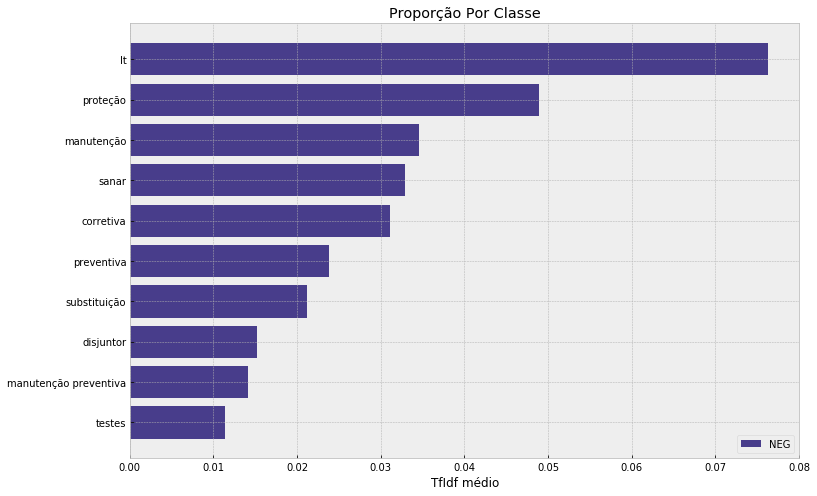

In [13]:
plt.figure(figsize=(12,8))

idx = (dataframe['CLASSE'] == 'POS').values
word_mean_neg = np.asarray(text_features[~idx].mean(axis=0))[0]
word_mean_pos = np.asarray(text_features[ idx].mean(axis=0))[0]
word_mean_diff = np.abs(word_mean_pos - word_mean_neg)

idx = np.argsort(word_mean_diff)[-nshow:]
vocabulary = np.array(list(vectorizer.vocabulary_.keys()))[idx].tolist()
yaxis = np.arange(nshow)

plt.barh(yaxis, word_mean_diff[idx], label='NEG', color='#483D8B')
plt.yticks(yaxis, vocabulary)

plt.legend()
plt.title('Proporção Por Classe')
plt.xlabel('TfIdf médio')


### <span style="color:Indigo"> 11. Distribuição do TfIdf Médio das Palavras 

Text(0.5, 0, '# TfIdf das palavras')

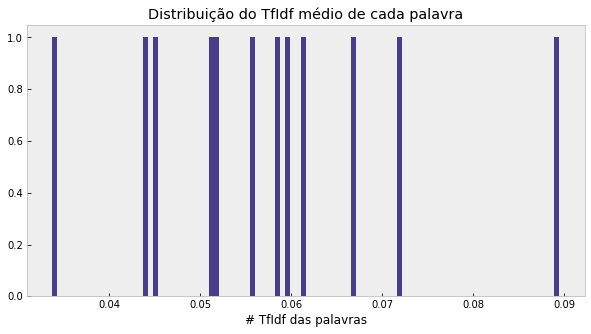

In [14]:
plt.figure(figsize=(10,5))

word_mean = np.asarray(text_features.mean(axis=0))[0]

df_tfidf = pd.Series(word_mean)
df_tfidf.index = list(vectorizer.vocabulary_.keys())
df_tfidf.hist(bins=100, color='#483D8B')


plt.grid()
plt.title('Distribuição do TfIdf médio de cada palavra')
plt.xlabel('# TfIdf das palavras')

### <span style="color:Indigo"> 12. Distribuição do TfIdf por Classe 

Text(0.5, 0, 'TfIdf médio')

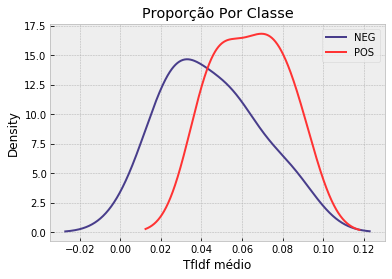

In [15]:
plt.figure(figsize=(6,4))

idx = (dataframe['CLASSE'] == 'POS').values
word_mean     = np.asarray(text_features.mean(axis=0))[0]
word_mean_neg = np.asarray(text_features[~idx].mean(axis=0))[0]
word_mean_pos = np.asarray(text_features[ idx].mean(axis=0))[0]


df_tfidf = pd.Series(word_mean_neg)
df_tfidf.index = list(vectorizer.vocabulary_.keys()).copy()
df_tfidf.plot.kde(color='#483D8B', label='NEG')

df_tfidf =pd.Series(word_mean_pos)
df_tfidf.index = list(vectorizer.vocabulary_.keys()).copy()
df_tfidf.plot.kde(color='#FF3333', label='POS')


plt.legend()
plt.title('Proporção Por Classe')
plt.xlabel('TfIdf médio')


## <span style="color:Indigo"> 13. Preliminar Results </span>

In [16]:
from sklearn import tree 
from sklearn import metrics

model = tree.DecisionTreeClassifier(max_depth=10)

Y = dataframe['CLASSE'].values
model.fit(text_features, Y)
Ydec = model.predict(text_features)
print(metrics.classification_report(Y, Ydec))

              precision    recall  f1-score   support

         NEG       0.55      0.11      0.19     88643
         POS       0.68      0.96      0.80    178675

    accuracy                           0.68    267318
   macro avg       0.62      0.53      0.49    267318
weighted avg       0.64      0.68      0.60    267318



### <span style="color:Indigo"> 13.1 Importância das Features </span>

Text(0.5, 1.0, 'Importância das Palavras')

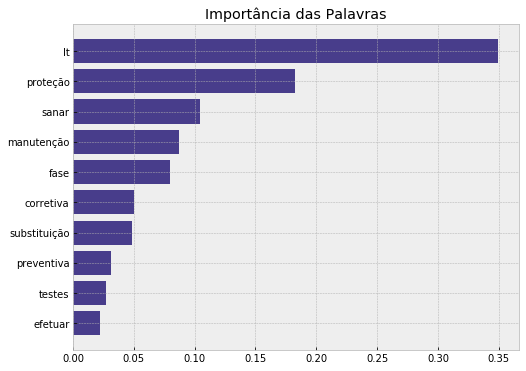

In [17]:
plt.figure(figsize=(8,6))


idx = np.argsort(model.feature_importances_)[-nshow:]
yaxis = np.arange(nshow)

plt.barh(yaxis, model.feature_importances_[idx],color='#483D8B')
plt.yticks(yaxis,np.array(list(vectorizer.vocabulary_.keys()))[idx])


plt.title('Importância das Palavras')

### <span style="color:Indigo"> 13.2 Visualização da Árvore </span>

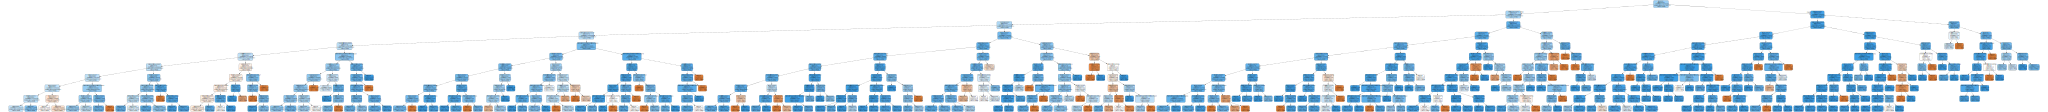

In [18]:
dot_data = tree.export_graphviz(model, out_file=None, 
                      feature_names=list(vectorizer.vocabulary_.keys()), 
                      class_names=model.classes_,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph